# Fitting a model to data - Six

## Hogg, Bovy, Lang exercise 6 in Python, NumPy

### David Craig, 2019 January

### Using my slice sampler 

### This is shortened version working on ex. 6 and making code more Pythonic

Here I am trying to work out how to set up my own MCMC slice sample to use the procedure for rejecting outliers to a linear fit 
that is described in Hogg, et. al. [arXiv 1008.4686](https://arxiv.org/abs/1008.4686).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, normal
import corner

In [2]:
def slicer(g, dim, x0, xargs, N=1000, w=0.5, m=10):
    """MCMC slice sampler: 
            g -- function or distribution
            dim -- number of dimensions
            x0 -- initial guess (vector of parameters)
            xargs -- extra arguments for g (often data-related)
            N -- number of values in Markov chain to return 
            w -- step-out width for slice sampling
            m -- maximum for step-out scaling
        Returns: (xs, likelies)
            xs[N, dim] -- resulting Markov chain (includes initial guess as 0th)
            likelies[N] -- vector of log-likelihoods of chain
            
        See: Neal, "Slice Sampling," The Annals of Statistics 2003, vol. 31 (705-767). This is available online
        --D. Craig converted from Julia mslicer, 2019 Jan 15.
        """
    # based on Julia mslicer, version in mslicer-keeplikes.ipynb
    xs = np.zeros((N, dim), dtype=np.float64)    # array (Markov chain) that will be returned
    xs[0,:] = x0             #initial guess into the chain
    x1 = np.zeros(dim)
    L = np.zeros(dim)
    R = np.zeros(dim)
    likelies = np.zeros(N)     # record log likelihoods
    likelies[0] = g(x0,xargs)  # get log-like of initial guess; avoid fencepost error
    way = np.zeros(dim)  # which axis to go along in space
    i = 1    # assumed start values for chain are recorded at xs[0,:]; this will be index of first generated point 
    while i < N:
        for d in range(dim):     # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + np.log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L + w * way
            V = rand()
            J = np.floor(m*V)
            K = (m - 1) - J
            while J > 0 and y < g(L,xargs):
                L = L - w * way
                J = J - 1
            while K > 0 and y < g(R,xargs):
                R = R + w * way
                K = K - 1
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while True: 
                U = rand()
                x1 = Lbar + U * (Rbar - Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs):
                    break # exit while loop
                if x1[d] < x0[d]:
                        Lbar = x1
                else: 
                        Rbar = x1
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            likelies[i] = y0 # record log-likelhood
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i >= N:
                break # catch case where we reach N in the middle of set of dimensions
    return xs, likelies 

In [3]:
# from Hogg, Bovy, Lang arXiv:1008.4686
# Data for fitting exercises
# ID, x, y, sigy, sigx, rhoxy
# the first four are "outliers"
d =[
    [  1.0, 201.0, 592.0, 61.0,  9.0, -0.84],
    [  2.0, 244.0, 401.0, 25.0,  4.0,  0.31],
    [  3.0,  47.0, 583.0, 38.0, 11.0,  0.64],
    [  4.0, 287.0, 402.0, 15.0,  7.0, -0.27],
    [  5.0, 203.0, 495.0, 21.0,  5.0, -0.33],
    [  6.0,  58.0, 173.0, 15.0,  9.0,  0.67],
    [  7.0, 210.0, 479.0, 27.0,  4.0, -0.02],
    [  8.0, 202.0, 504.0, 14.0,  4.0, -0.05],
    [  9.0, 198.0, 510.0, 30.0, 11.0, -0.84],
    [ 10.0, 158.0, 416.0, 16.0,  7.0, -0.69],
    [ 11.0, 165.0, 393.0, 14.0,  5.0,  0.3 ],
    [ 12.0, 201.0, 442.0, 25.0,  5.0, -0.46],
    [ 13.0, 157.0, 317.0, 52.0,  5.0, -0.03],
    [ 14.0, 131.0, 311.0, 16.0,  6.0,  0.5 ],
    [ 15.0, 166.0, 400.0, 34.0,  6.0,  0.73],
    [ 16.0, 160.0, 337.0, 31.0,  5.0, -0.52],
    [ 17.0, 186.0, 423.0, 42.0,  9.0,  0.9 ],
    [ 18.0, 125.0, 334.0, 26.0,  8.0,  0.4 ],
    [ 19.0, 218.0, 533.0, 16.0,  6.0, -0.78],
    [ 20.0, 146.0, 344.0, 22.0,  5.0, -0.56]
]

In [5]:
data = np.array(d)

In [6]:
x = data[:,1] 
y = data[:,2]
sig_y = data[:,3]  #scatter in y
sig_x = data[:,4]  #scatter in x
rho_xy = data[:,5];  #covariance
# this names all data nicely

In [7]:
# ignore the first four points
good = range(4,20)
xt = x[good]
yt = y[good]
s_xt = sig_x[good]
s_yt = sig_y[good];

## Model good/bad or foreground/background points

We want to add to the model

-  $N$ binary integers $q_i$: $q_i = 1$ if the $i$th point is good, 0 if bad.
-  $P_b$ the _prior_ probability that any one data point is bad (that is, a proportion of sorts.)
-  $Y_b, V_b$ the (prior) mean and variance of the distribution of bad points in $y$, the $y$ of the fit.

The gives $N+3$ extra parameters besides the ones for the slope, intercept, and noise of the simple linear mode.

Remember that $\{y_i\}_{i=1}^N$ is the set of data points in $y$.
Then the likelihood of the data is:
$$
    {\cal L} = p \left( \{y_i\}_{i=1}^N \vert m, b, \{q_i\}_{i=1}^N, Y_b,V_b, I \right)
$$

$$
    {\cal L} = \prod_{i=1}^N \left[ p_{fg} \left( \{y_i\}_{i=1}^N \vert m, b, I \right) \right]^{q_i}
    \left[ p_{bg} \left( \{y_i\}_{i=1}^N \vert Y_b, V_b, I \right) \right]^{[1-q_i]}
$$

$$ 
{\cal L} = \prod_{i=1}^N 
\left[ \frac{1}{\sqrt{2\pi\sigma_{yi}^2} }
\exp \left( -\frac{[y_i - m x_i - b]^2}{2\sigma_{yi}^2} \right) \right]^{q_i}
\left[ \frac{1}{\sqrt{2\pi[V_b + \sigma_{yi}^2]} }
\exp \left( -\frac{[y_i - Y_b]^2}{2[V_b +\sigma_{yi}^2]} \right) \right]^{[1-q_i]}
$$
where $p_{fg}(\cdot)$ and $p_{bg}(\cdot)$ are the generative mdoels for the foreground (good) and background (bad) points. **This is equation 13 in Hogg++**

"Because we are permitting data rejection, there is an important prior probability on the $\{q_i\}_{i=1}^N$
that penalizes each rejection:

$$
    p \left(m, b, \{q_i\}_{i=1}^N, P_b, Y_b, V_b \vert I \right)
    = p\left(\{q_i\}_{i=1}^N \vert P_b, I\right) p\left(m, b, P_b Y_b, V_b ,I\right)
$$

$$
     p\left(\{q_i\}_{i=1}^N \vert P_b, I\right) = \prod_{i=1}^{N} \left[1 - P_b\right]^{q_i} P_b^{[1-q_i]},
$$
that is, the binomial probability of the particular sequence $\{q_i\}_{i=1}^N$." 

The above things look like they need to be logarithmed to get the log-likelihood.



**NOTE** if one looks down to the paragraphs before equation (17), it is argued that the $q_i$ marginalize or sum down to (eq 17):
$$ 
{\cal L} \propto \prod_{i=1}^N \left[
\frac{1 - P_b}{\sqrt{2 \pi \sigma_{yi}^2}} 
\exp \left( -\frac{[y_i - m x_i - b]^2}{2\sigma_{yi}^2} \right) 
+
\frac{P_b}{\sqrt{2\pi[V_b + \sigma_{yi}^2]} }
\exp \left( -\frac{[y_i - Y_b]^2}{2[V_b +\sigma_{yi}^2]} \right)
\right]
$$

**SEEK TO UNDERSTAND THIS MARGINALIZATION.** 
It's a form of "mixture model." 
See also [Press, 1996](https://arxiv.org/abs/astro-ph/9604126)

I found Foreman-Mackey's explanation of this, see [F-M notebook](mixture-models.ipynb)
or the same in his [blog post on mixture models](https://dfm.io/posts/mixture-models/) where there is some relevant info in his replies to comments.

This looks a lot more tractable! This only adds 3 parameters vs. $N+3$.
There is not a digital parameter $q_i$ for each point
$(x_i,y_i)$ now. The log-likelihood is just going to be: 

$$ 
\ln {\cal L} \propto \sum_{i=1}^N \ln \left[
\frac{1 - P_b}{\sqrt{2 \pi \sigma_{yi}^2}} 
\exp \left( -\frac{[y_i - m x_i - b]^2}{2\sigma_{yi}^2} \right) 
+
\frac{P_b}{\sqrt{2\pi[V_b + \sigma_{yi}^2]} }
\exp \left( -\frac{[y_i - Y_b]^2}{2[V_b +\sigma_{yi}^2]} \right)
\right]
$$

Now let's try this outlier rejection trick (code here for variable reference from above):

    x = data[:,1] 
    y = data[:,2]
    sig_y = data[:,3]  #scatter in y
    sig_x = data[:,4]  #scatter in x
    rho_xy = data[:,5];  #covariance
    # this names all data nicely

In [8]:
def lnlike(parms, d):
    """Log-likelihood for mixture model where there is an average probability 
    for a bad or background point as interloper
    parms -- vector of parameters: m, b, Pbg, Ybg, Vbg
    d -- array of data to compare with model, columns: x, y, sigy"""
    m, b, Pbg, Ybg, Vbg = parms  #slope, intercept, prob bkgrd, mean bkrg, variance bkgrd.
    x, y, sigy = d[:,0], d[:,1], d[:,2] # note indices
    vy = sigy**2    #square for variance
    lnL = np.sum(np.log(
    ( (1-Pbg)/np.sqrt(2*np.pi*vy) ) * np.exp( -((y-m*x-b)**2)/(2*vy) ) +
        ( Pbg/np.sqrt(2*np.pi*(Vbg+vy)) ) * np.exp( -((y-Ybg)**2)/(2*(Vbg+vy)) )
    ))
    return lnL

In [167]:
d3 = data[:,1:4] # take only relevant columns, drop index col and trailing cols.
p = [2.4, 10, 0.2, 500, 2000]
# lnlike(p, d3) #just a check

In [165]:
def lnprior(parms):
    """a somewhat scandalous prior"""
    m,b, Pbg, Ybg, Vbg = parms
    if Pbg < 0.0 or Pbg > 0.9:
        return -np.inf
    elif Ybg < 300 or Ybg > 700:
        return -np.inf
    elif Vbg < 0 or Vbg > 4000:
        return -np.inf
    elif m <= 0: 
        return -np.inf #it's pretty obviously positive
    else:
        return -0.5 * np.log(1 + m**2) 


In [168]:
lnprior(p)

-0.9555114450274363

In [169]:
def lnposterior(parms, data):
    """log posterior = log prior + log likelihood
    parms -- vector of parameters
    data -- data for modeling"""
    lp = lnprior(parms)
    if not np.isfinite(lp):
        return -np.inf      #catch any bad prior vals due to numerical probls
    else:
        return lp + lnlike(parms, data)


In [170]:
lnposterior(p, d3)

-109.45272984254036

In [173]:

nslicers = 5
p0 = [2.25, 30, 0.2, 500, 1500] # initial guesses
p = np.zeros((nslicers, 5))
for i in range(nslicers):
    for j in range(5):
        p[i,j] = p0[j] + p0[j]*normal(scale=0.2)
        

In [174]:
%%time
Nchain = 10000
res, likes = slicer(lnposterior, 5, p[0,:], d3, N=Nchain)
for n in range(1,5):
    print(n)
    resn, liken = slicer(lnposterior, 5, p[n,:], d3, N=Nchain)
    res = np.append(res, resn, axis=0)
    likes = np.append(likes, liken, axis=0)
# This sets up 5 sets of slicers, runs them sequentially, and then concatenates them all into a longer
# list of values for plotting.

1
2
3
4
CPU times: user 1min 18s, sys: 264 ms, total: 1min 18s
Wall time: 1min 18s


In [153]:
np.shape(res)

(50000, 5)

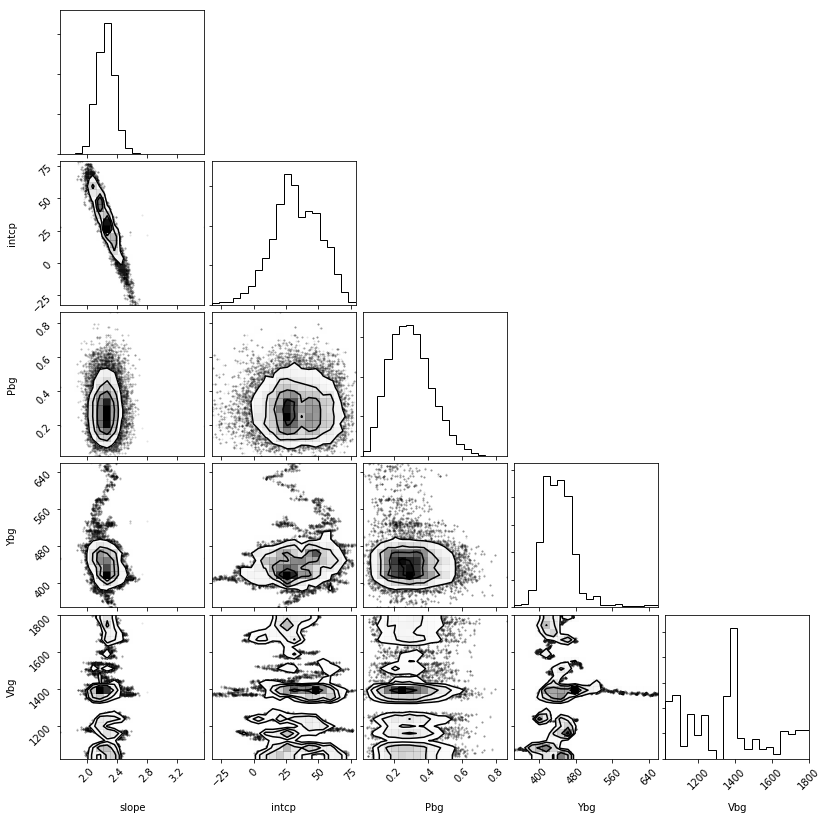

In [175]:
cp = corner.corner(res, labels = ["slope", "intcp", "Pbg", "Ybg", "Vbg"])

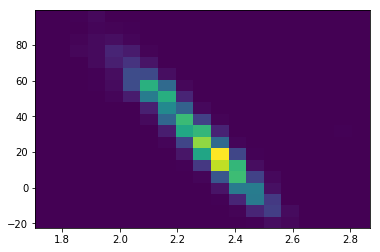

In [155]:
hh = plt.hist2d(res[:,0], res[:,1],bins=19)

### Use the histogram binning to find the MAP value for m,b

In [156]:
mflat = np.argmax(hh[0]) #get the array of bin values (gives flattened index)

In [157]:
maxm, maxb = np.unravel_index(mflat,np.shape(hh[0])) #indices of hist peak
print("peak of histogram at: ", maxm, maxb)

peak of histogram at:  10 6


In [158]:
hh[0][maxm,maxb]  #see how many we have there (just a check)

3226.0

In [159]:
m_MAP = (hh[1][maxm]+hh[1][maxm+1])/2  # average edges of bin (? check)
m_MAP

2.348615569691815

In [160]:
b_MAP = (hh[2][maxb]+hh[2][maxb+1])/2
b_MAP

19.253677168520635

In [161]:
sampi = np.random.choice(range(Nchain), 20) # random set of indices
ysamp = res[sampi, :]  #this is a choice from the sampling of 20 values of  parameters

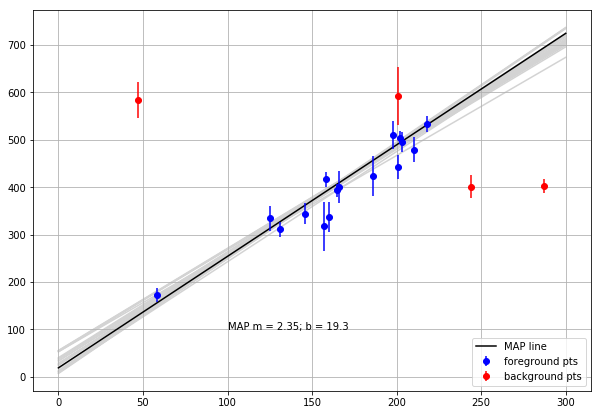

In [162]:
xp = np.linspace(0,300)# for plotting lines
plt.figure(figsize=(10,7))
for s in ysamp:
    plt.plot(xp, xp*s[0]+s[1], color='lightgrey',zorder=1)
plt.plot(xp, xp*m_MAP + b_MAP, color='black', zorder=2, label="MAP line")
plt.errorbar(data[4:,1], data[4:,2], 
             yerr=data[4:,3],fmt='bo',zorder=3,
            label="foreground pts")
plt.errorbar(data[:4,1], data[:4,2], 
             yerr=data[:4,3],fmt='ro', zorder=3,
            label="background pts");
plt.legend(loc=4)  #lower right
st = "MAP m = {:4.2f}; b = {:4.1f}".format(m_MAP, b_MAP)
plt.text(100,100,st);
plt.grid()

In [141]:
print(np.median(res[:,2])) # median outlier probability

0.28083104144325205
